# DNA Classification with Stacking + RandomizedSearchCV
This notebook uses a stacking ensemble (Random Forest + Gradient Boosting + Logistic Regression) with hyperparameter tuning using RandomizedSearchCV.

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load DNA dataset
data = pd.read_csv(r'dna.csv')

# Basic info
print("Dataset shape:", data.shape)
print("Missing values in each column:\n", data.isnull().sum())

# Adjust class labels to start from 0
data['class'] = data['class'] - 1
print("Distribution of classes:\n", data['class'].value_counts())

Dataset shape: (3186, 181)
Missing values in each column:
 A0       0
A1       0
A2       0
A3       0
A4       0
        ..
A176     0
A177     0
A178     0
A179     0
class    0
Length: 181, dtype: int64
Distribution of classes:
 class
2    1654
0     767
1     765
Name: count, dtype: int64


In [5]:
# Split features and target
X = data.drop('class', axis=1)
y = data['class']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Define base models and meta-model
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

meta_model = LogisticRegression(max_iter=500)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Pipeline with scaler
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', stacking_model)
])

In [7]:
# RandomizedSearchCV hyperparameter grid
param_grid = {
    'classifier__final_estimator__C': [0.1, 1, 10],
    'classifier__rf__n_estimators': [50, 100, 200],
    'classifier__gb__learning_rate': [0.01, 0.1, 0.2]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Train the model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,Pipeline(step..._iter=500)))])
,param_distributions,"{'classifier__final_estimator__C': [0.1, 1, ...], 'classifier__gb__learning_rate': [0.01, 0.1, ...], 'classifier__rf__n_estimators': [50, 100, ...]}"
,n_iter,20
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [8]:
# Predictions
y_pred = random_search.predict(X_test)
y_prob = random_search.predict_proba(X_test)

# Evaluation
print("Best parameters found:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best parameters found: {'classifier__rf__n_estimators': 100, 'classifier__gb__learning_rate': 0.1, 'classifier__final_estimator__C': 1}
Accuracy: 0.9655172413793104

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       153
           1       0.94      0.94      0.94       168
           2       0.99      0.97      0.98       317

    accuracy                           0.97       638
   macro avg       0.96      0.96      0.96       638
weighted avg       0.97      0.97      0.97       638



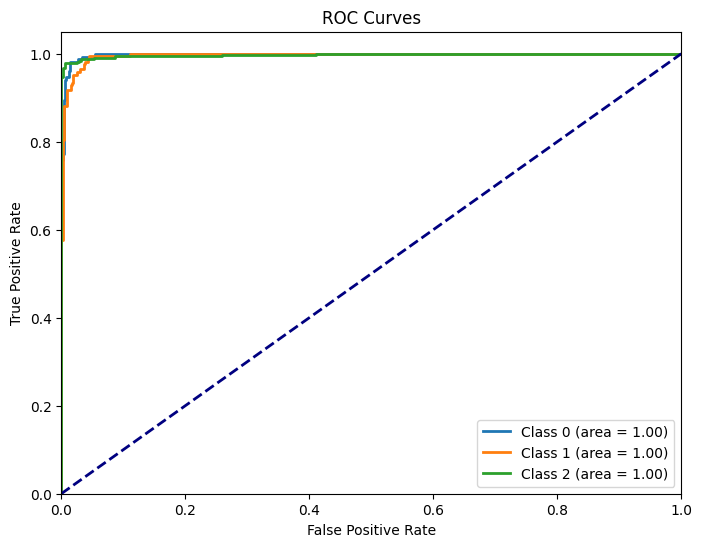

In [9]:
# Plot ROC curves for each class
n_classes = y_prob.shape[1]
plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

In [10]:
# Cross-validation scores on full data
cv_scores = cross_val_score(random_search.best_estimator_, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.97492163 0.96075353 0.9733124  0.96232339 0.96389325]
Mean CV score: 0.9670408409324665
